# DenseNet 

마지막

In [2]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

# 폴더 이동
%cd drive/My\ Drive/AI-SCHOOL/CXR
!pwd


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/AI-SCHOOL/CXR
/content/drive/My Drive/AI-SCHOOL/CXR


In [3]:
from tensorflow.keras.applications.densenet import DenseNet201, DenseNet169
from tensorflow.keras.utils import to_categorical
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf 
import numpy as np 
import glob as gb
import cv2
import os

In [4]:
# 하이퍼파라미터
# epochs = 50

image_size = 224
LABELS = {'PNEUMONIA': 0, 'NORMAL': 1, 'COVID19': 2}

In [5]:
# path 설정 
path_data = "./data"

path_PNEUMONIA = path_data + "/PNEUMONIA"
path_NORMAL = path_data + "/NORMAL"
path_COVID19 = path_data + "/COVID"

In [6]:
len_PNEUMONIA = len(os.listdir(path_PNEUMONIA))
len_NORMAL = len(os.listdir(path_NORMAL))
len_COVID = len(os.listdir(path_COVID19))

print(len_PNEUMONIA)
print(len_NORMAL)
print(len_COVID)

print("total: ", len_COVID + len_NORMAL + len_PNEUMONIA)

7293
11488
1344
total:  20125


In [7]:
# # 이미지 확인
# plt.figure(figsize=(20, 10))
# for i in range(1, 4):
#     plt.subplot(3, 3, i)
#     img = plt.imread(path_NORMAL + f"/NORMAL ({i}).png")
#     plt.imshow(img, cmap='gray')
#     plt.title("NORMAL")


# plt.figure(figsize=(20, 10))
# for i in range(1, 4):
#     plt.subplot(3, 3, i)
#     img = plt.imread(path_COVID19 + f"/COVID-19 ({i}).png")
#     plt.imshow(img, cmap='gray')
#     plt.title("COVID-19")


# plt.figure(figsize=(20, 10))
# for i in range(1, 4):
#     plt.subplot(3, 3, i)
#     img = plt.imread(path_PNEUMONIA + f"/Viral Pneumonia ({i}).png")
#     plt.imshow(img, cmap='gray')
#     plt.title("Viral Pneumonia")

# Data augmentation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 학습 및 검증 데이터용 ImageDataGenerator 생성해 놓기 
train_datagen = ImageDataGenerator(rescale=1./255., 
                                #    horizontal_flip = True, 
                                #    shear_range = 0.2,
                                #    zoom_range = 0.2,
                                #    width_shift_range = 0.2,
                                #    height_shift_range = 0.2,
                                   validation_split = 0.25)

#검증데이터는 정규화 외에 따로 조정 없음 
valid_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.25)

#flow_from_directory()는 앞서 배운 flow()와 비슷, 단 경로를 통채로 가져올 수 있음 
train_generator = train_datagen.flow_from_directory(directory = path_data, #저장 경로 
                                                    subset = 'training',   
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

valid_generator = valid_datagen.flow_from_directory(directory = path_data,
                                                    subset = 'validation',
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

Found 15094 images belonging to 3 classes.
Found 5031 images belonging to 3 classes.


In [9]:
def getCode(label):
    return LABELS[label]

def getLabel(n):
    for key, val in LABELS.items():
        if n == val:
            return key

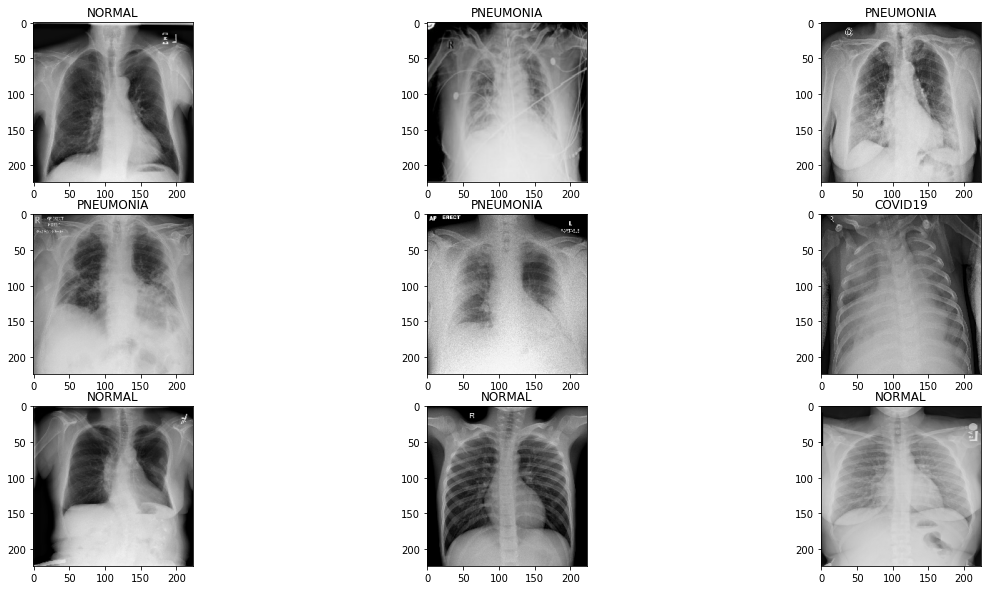

In [10]:
plt.figure(figsize=(20,10))
lst = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
cnt = 1
for i in lst:
    plt.subplot(3, 3, cnt)
    plt.imshow(train_generator.__getitem__(i)[0][0])
    plt.title(getLabel(np.argmax(train_generator.__getitem__(i)[1])) )
    cnt += 1
plt.show()

# DenseNet

In [11]:
# densenet = DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)
densenet = DenseNet169(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

densenet.trainable = False

# for layer in densenet.layers:
#   layer.trainable = False

51879936/51877672 [==============================] - 1s 0us/step


In [12]:
# densenet.summary()

In [13]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = densenet(image_batch)

print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

print(prediction_batch.shape)

(1, 7, 7, 1664)
(1, 1664)
(1, 3)


In [14]:
inputs = tf.keras.Input(shape=(224, 224, 3))

x = densenet(inputs, training=False)
x = global_average_layer(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [15]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss="categorical_crossentropy", metrics=['accuracy'])

In [16]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 4995      
Total params: 12,647,875
Trainable params: 4,995
Non-trainable params: 12,642,880
_________________________________________________________________


In [17]:
len(model.trainable_variables)

2

In [18]:
initial_epochs = 10

history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=valid_generator)

Epoch 1/10
15094/15094 [==============================] - 3814s 253ms/step - loss: 0.2547 - accuracy: 0.9084 - val_loss: 0.1298 - val_accuracy: 0.9581
Epoch 2/10
15094/15094 [==============================] - 579s 38ms/step - loss: 0.1522 - accuracy: 0.9477 - val_loss: 0.1071 - val_accuracy: 0.9620
Epoch 3/10
15094/15094 [==============================] - 574s 38ms/step - loss: 0.1290 - accuracy: 0.9558 - val_loss: 0.1016 - val_accuracy: 0.9672
Epoch 4/10
15094/15094 [==============================] - 573s 38ms/step - loss: 0.1144 - accuracy: 0.9626 - val_loss: 0.0993 - val_accuracy: 0.9640
Epoch 5/10
15094/15094 [==============================] - 567s 38ms/step - loss: 0.1057 - accuracy: 0.9648 - val_loss: 0.0759 - val_accuracy: 0.9752
Epoch 6/10
15094/15094 [==============================] - 566s 37ms/step - loss: 0.0988 - accuracy: 0.9673 - val_loss: 0.0749 - val_accuracy: 0.9748
Epoch 7/10
15094/15094 [==============================] - 570s 38ms/step - loss: 0.0930 - accuracy: 0.96

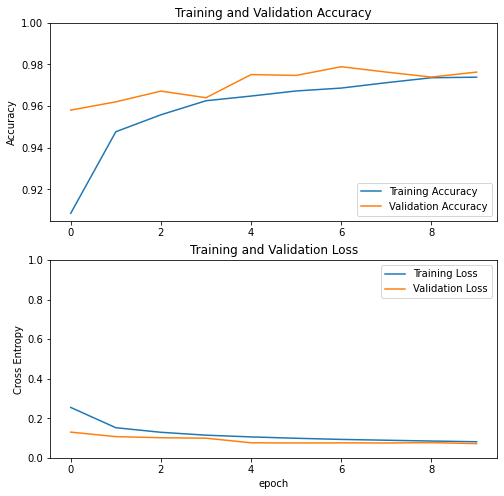

In [19]:
# 학습 곡선
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
model.evaluate(valid_generator)

5031/5031 [==============================] - 135s 27ms/step - loss: 0.0718 - accuracy: 0.9763


[0.07177563011646271, 0.9763466715812683]

## 미세조정

In [21]:
densenet.trainable = True

In [22]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(densenet.layers))

# Fine-tune from this layer onwards
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in densenet.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  595


In [24]:
# model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10), loss="categorical_crossentropy", metrics=['accuracy'])

# model.compile(loss=tf.keras.losses.categorical_crossentropy(from_logits=True),
#               optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
#               metrics=['accuracy'])

In [25]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 4995      
Total params: 12,647,875
Trainable params: 10,313,603
Non-trainable params: 2,334,272
_________________________________________________________________


In [26]:
len(model.trainable_variables)

340

In [27]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_generator)

Epoch 10/20
15094/15094 [==============================] - 973s 64ms/step - loss: 0.1278 - accuracy: 0.9572 - val_loss: 0.0545 - val_accuracy: 0.9853
Epoch 11/20
15094/15094 [==============================] - 969s 64ms/step - loss: 0.0665 - accuracy: 0.9775 - val_loss: 0.0882 - val_accuracy: 0.9678
Epoch 12/20
15094/15094 [==============================] - 973s 64ms/step - loss: 0.0442 - accuracy: 0.9852 - val_loss: 0.0378 - val_accuracy: 0.9903
Epoch 13/20
15094/15094 [==============================] - 973s 64ms/step - loss: 0.0353 - accuracy: 0.9887 - val_loss: 0.0317 - val_accuracy: 0.9915
Epoch 14/20
15094/15094 [==============================] - 976s 65ms/step - loss: 0.0263 - accuracy: 0.9922 - val_loss: 0.0297 - val_accuracy: 0.9903
Epoch 15/20
15094/15094 [==============================] - 973s 64ms/step - loss: 0.0229 - accuracy: 0.9931 - val_loss: 0.0277 - val_accuracy: 0.9928
Epoch 16/20
15094/15094 [==============================] - 974s 65ms/step - loss: 0.0208 - accuracy:

In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



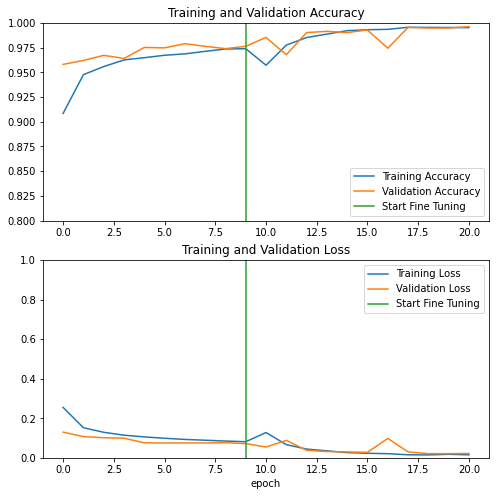

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
model.save('Densenet_model.h5')

In [38]:
model.evaluate(valid_generator)

5031/5031 [==============================] - 134s 27ms/step - loss: 0.0220 - accuracy: 0.9962


[0.02201545424759388, 0.9962233901023865]

In [ ]:
# epochs = 20
# history = model.fit(train_generator,
#                     epochs=epochs,
#                     validation_data=valid_generator,
#                     callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_loss')])

Epoch 1/20
15072/15072 [==============================] - 2694s 179ms/step - loss: 0.2001 - accuracy: 0.9312 - val_loss: 0.1060 - val_accuracy: 0.9610
Epoch 2/20
15072/15072 [==============================] - 483s 32ms/step - loss: 0.1428 - accuracy: 0.9539 - val_loss: 0.1276 - val_accuracy: 0.9608
Epoch 3/20
15072/15072 [==============================] - 471s 31ms/step - loss: 0.1230 - accuracy: 0.9596 - val_loss: 0.0567 - val_accuracy: 0.9823
Epoch 4/20
15072/15072 [==============================] - 474s 31ms/step - loss: 0.1116 - accuracy: 0.9626 - val_loss: 0.2344 - val_accuracy: 0.9198
Epoch 5/20
15072/15072 [==============================] - 454s 30ms/step - loss: 0.1030 - accuracy: 0.9668 - val_loss: 0.0661 - val_accuracy: 0.9791
Epoch 6/20
15072/15072 [==============================] - 432s 29ms/step - loss: 0.1019 - accuracy: 0.9677 - val_loss: 0.0854 - val_accuracy: 0.9787


In [ ]:
# 학습된 모델 저장하기
# model.save('densenet_3.h5')

In [31]:
# 예측하기
pred = model.predict(valid_generator)

In [35]:
valid_generator

In [36]:
y_test=[]
for i in tqdm(range(5031)):
    y_test.extend(valid_generator.__getitem__(i)[1])

print(len(y_test))
y_test = np.array(y_test)

y_test=np.argmax(y_test, axis=1)
# pred= np.argmax(pred, axis=1)

# print("pred: ",len(pred))
print("y_test: ",len(y_test))

100%|██████████| 5031/5031 [00:49<00:00, 102.04it/s]

5031
y_test:  5031


In [39]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(pred,y_test)

print(cm)

[[  16  200  116]
 [ 199 1614 1064]
 [ 121 1058  643]]


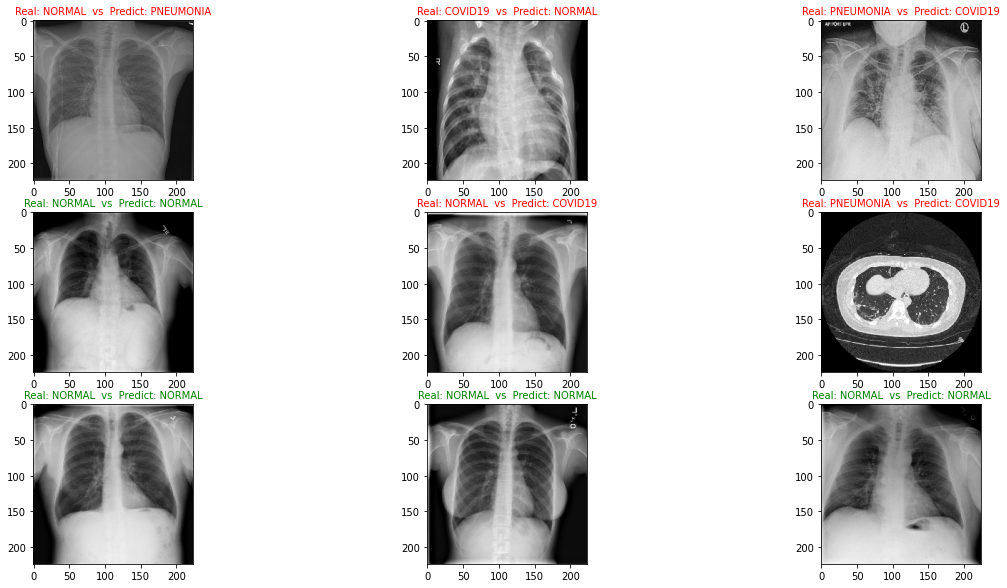

In [37]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(valid_generator.__getitem__(i)[0][0], cmap='gray')
    color = "green" if y_test[i] == pred[i] else "red"
    plt.title(f"Real: {getLabel(y_test[i])   }  vs  Predict: {getLabel(pred[i])}", color=color, fontsize=10)
plt.show()

In [ ]:
# 예측 함수
def diseasePredict(file_path, ml):
    LABELS = {'PNEUMONIA': 0, 'NORMAL': 1, 'COVID19': 2}

    image = cv2.imread(file_path)
    # image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)
    image = cv2.resize(image, dsize=(224, 224))
    image = image / 255.

    reshaped_image = np.expand_dims(image, axis=0)

    pred = ml.predict(reshaped_image)
    pred_code= np.argmax(pred,axis=1)

    disease = getLabel(pred_code)

    return disease


# 예측 이미지 그리기
def showImage(file_path, ml):
    image = cv2.imread(file_path)
    image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)

    plt.imshow(image, cmap='gray')

    disease = diseasePredict(file_path, ml)
    plt.title(disease)
    plt.show()

In [ ]:
path = "./predict_test_img/COVID-1.jpg"
# ml = tf.keras.models.load_model('densenet_3.h5')
ml = model

print(diseasePredict(path, ml))

showImage(path, ml)

In [ ]:
# model.save('densenet_333.h5')